In [1]:
import torch
import numpy as np
import time
import os
from typing import Dict, Optional, Sequence, Tuple

import matplotlib.pyplot as plt
import imageio.v2 as imageio

import torchvision
from torchvision.models.detection import (
    ssdlite320_mobilenet_v3_large,
    SSDLite320_MobileNet_V3_Large_Weights,
    ssd300_vgg16,
    SSD300_VGG16_Weights
)
from torchvision.transforms import v2
from torchvision.ops import box_iou, box_convert, complete_box_iou
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from pathlib import Path

import CarImageClass

from SSD_from_scratch import mySSD
from SSD_trainer import SSD_train, plot_losses, collate_detection, ConditionalIoUCrop, load_checkpoint, build_targets

# device = "cuda" if torch.cuda.is_available() else "cpu"
# just use cpu for this file
device = 'cpu'

# desktop or laptop
machine = 'laptop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"C:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

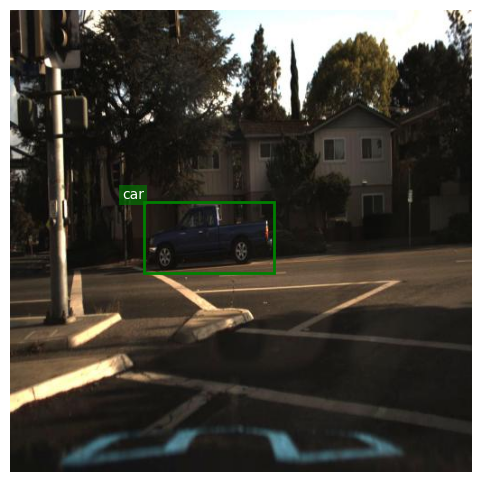

In [3]:
min_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Resize((300, 300), antialias=False),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

toy_set = CarImageClass.ImageClass(targ_dir=train_path, transform=min_tfms, file_pct=1, rand_seed=724)

toy_set.show_with_box(index=69, color='g', lw=2, label=True);

In [5]:
test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

toy_set_tfms = CarImageClass.ImageClass(targ_dir=train_path, transform=test_tfms, file_pct=1, rand_seed=724)

toy_dataloader = DataLoader(toy_set_tfms, 
                              batch_size=1, 
                              shuffle=False, 
                              num_workers=0,
                              collate_fn=collate_detection
                              )

# (images, targets) = next(iter(toy_dataloader))

# send to device
# images tensor is normalized (i.e. values between 0 and 1)
# need to normalize target bounding boxes
# images = images.to(device)
# for i in range(len(targets)):
#     for key in targets[i]:
#         targets[i][key] = targets[i][key].to(device=device)

for batch, (imgs, tgts) in enumerate(toy_dataloader):
    if batch == 69:
        images = imgs.to(device)
        targets = tgts
        for i in range(len(targets)):
            for key in targets[i]:
                targets[i][key] = targets[i][key].to(device=device)
                # if key == 'boxes':
                #     targets[i][key] = targets[i][key] / torch.tensor([300,300,300,300], device=device, dtype=torch.float32)
        break

Step 1 - create prior boxes

In [6]:
priors_cxcywh = mySSD.create_default_boxes()
priors_xyxy = box_convert(boxes=priors_cxcywh, in_fmt='cxcywh', out_fmt='xyxy').clamp(0, 1)

priors_xyxy_38 = priors_xyxy[0:38*38*4]
priors_xyxy_19 = priors_xyxy[38*38*4:38*38*4+19*19*6]
priors_xyxy_10 = priors_xyxy[38*38*4+19*19*6:38*38*4+19*19*6+10*10*6]
priors_xyxy_5 = priors_xyxy[38*38*4+19*19*6+10*10*6:38*38*4+19*19*6+10*10*6+5*5*6]
priors_xyxy_3 = priors_xyxy[38*38*4+19*19*6+10*10*6+5*5*6:38*38*4+19*19*6+10*10*6+5*5*6+3*3*4]
priors_xyxy_1 = priors_xyxy[38*38*4+19*19*6+10*10*6+5*5*6+3*3*4:38*38*4+19*19*6+10*10*6+5*5*6+3*3*4+1*1*4]

Step 2 - determine which prior box matches the 'best' with the ground truth box

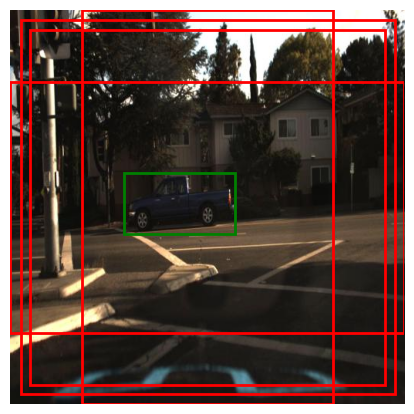

In [5]:
toy_set.show_with_box(index=69, color='g', lw=2, label=False, pred_dict={"boxes": priors_xyxy_1}, pred_color='r', lw_pred=2, pred_label=False, pred_ref='normalized');

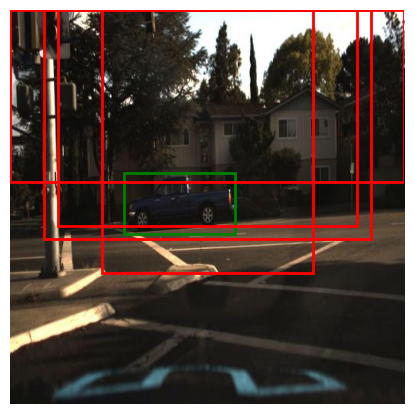

In [6]:
toy_set.show_with_box(index=69, color='g', lw=2, label=False, pred_dict={"boxes": priors_xyxy_3[4:8]}, pred_color='r', lw_pred=2, pred_label=False, pred_ref='normalized');

In [7]:
def make_priors_gif(toy_set, priors_xyxy, gif_path, mult, n_start=0, n_end=9, duration=500):

    if (mult != 1) & (mult != 4) & (mult != 6):
        raise ValueError(f"mult should be 1, 4 or 6, recieved {mult}.")
    frames = []

    for n in range(n_start, n_end):
        # Get the figure that show_with_box actually creates
        fig = toy_set.show_with_box(
            index=69,
            color='g',
            lw=2,
            label=False,
            pred_dict={"boxes": priors_xyxy[mult*n:mult*(n+1)]},
            pred_color='r',
            lw_pred=2,
            pred_label=False,
            pred_ref='normalized'
        )

                # Render and grab pixels
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()

        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        buf = buf.reshape((h, w, 4))  # [H, W, 4]

        # Take the first axes (assuming show_with_box creates one main axes)
        ax = fig.axes[0]
        bbox = ax.get_window_extent()  # in display (pixel) coords
        x0, y0, x1, y1 = bbox.extents
        x0, y0, x1, y1 = [int(v) for v in (x0, y0, x1, y1)]

        # Crop to axes region
        buf_cropped = buf[y0:y1, x0:x1, :]  # [h_c, w_c, 4]
        img = buf_cropped[..., :3].copy()   # RGB

        # ---- Add a small white border around the cropped image ----
        border = 4  # adjust this to taste
        h_c, w_c, _ = img.shape

        # White background (255,255,255)
        framed = np.full(
            (h_c + 2*border, w_c + 2*border, 3),
            255,
            dtype=np.uint8
        )

        # Put the image in the center
        framed[border:border + h_c, border:border + w_c, :] = img

        frames.append(framed)

        plt.close(fig)

    imageio.mimsave(gif_path, frames, duration=duration, loop=0)
    return gif_path

In [8]:
# create .gifs
# make_priors_gif(toy_set, priors_xyxy_3, mult=4, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_3.gif",
#                            n_start=0, n_end=3*3, duration=500)
# make_priors_gif(toy_set, priors_xyxy_5, mult=6, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_5.gif",
#                            n_start=0, n_end=5*5, duration=500)
# make_priors_gif(toy_set, priors_xyxy_10, mult=6, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_10.gif",
#                            n_start=0, n_end=10*10, duration=500)
# make_priors_gif(toy_set, priors_xyxy_19, mult=6, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_19.gif",
#                            n_start=0, n_end=19*19, duration=100)
# make_priors_gif(toy_set, priors_xyxy_38, mult=4, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_38.gif",
#                            n_start=0, n_end=38*38, duration=50)

We can visualize all of the priors on our image.  The .gif below shows all priors corresponding to the conv_8_2 layer, with a total of 10 * 10 * 6 = 600 boxes.

![description](figures/priors_10.gif)

Step 3 - compute IoU between ground truth box and each prior box to find best match

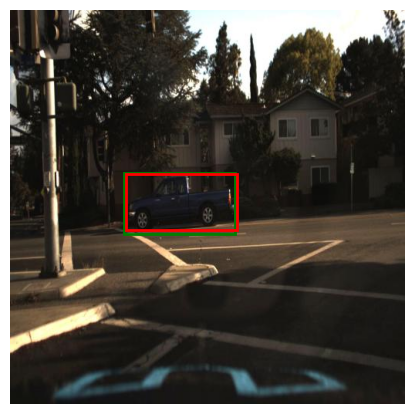

In [9]:
# IoU and matching
# targets have not been normalized
iou = complete_box_iou(priors_xyxy, targets[0]['boxes'] / torch.tensor([300,300,300,300], device=device, dtype=torch.float32))           # [P,G]
# Force bipartite matches: each GT gets its best prior
best_prior_per_gt = iou.argmax(dim=0)

toy_set.show_with_box(index=69, color='g', lw=2, label=False, pred_dict={"boxes": priors_xyxy[best_prior_per_gt]}, pred_color='r', lw_pred=2, pred_label=False, pred_ref='normalized');

In [10]:
# this guarantees the selection of atleast this prior
# example: best IoU is 0.3 but IoU threshold is 0.5
iou[best_prior_per_gt, torch.arange(1, device=device)] = 2.0

In [11]:
# this gets us the index of priors with IoU >= 0.5
best_gt_per_prior  = iou.argmax(dim=1)
best_iou_per_prior = iou.gather(1, best_gt_per_prior.view(-1,1)).squeeze(1)
pos_mask = best_iou_per_prior >= 0.5 # 0.5 was chosen as IoU threshold
print(pos_mask)

tensor([False, False, False,  ..., False, False, False])


In [12]:
# create .gif
# make_priors_gif(toy_set, priors_xyxy[pos_mask], mult=1, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_above_threshold.gif",
#                            n_start=0, n_end=priors_xyxy[pos_mask].shape[0], duration=500)

Now we can visualize all priors above the IoU threshold of 0.5!

![Priors above IoU threshold](figures/priors_above_threshold.gif)

In [13]:
# Since there is only 1 target ground truth box, matched_gt_cxcywh is just the only GT box repeated 8732 times
# This structure is important for handling multiple GT boxes in an image
gt_boxes_cxcywh = box_convert(targets[0]['boxes'], in_fmt='xyxy', out_fmt='cxcywh').to(device=device)
matched_gt_cxcywh = gt_boxes_cxcywh[best_gt_per_prior]  # [P,4]

Now that we have matched our ground truth (GT) boxes to a prior, we can compute their "distance" in the following way.  Let $g = (c_{x}^{g}, c_{y}^{g}, w^{g}, h^{g})$, $p = (c_{x}^{p}, c_{y}^{p}, w^{p}, h^{p})$ denote the matched GT, prior boxes, respectively.  The center $t_{x}$, $t_{y}$ and size $t_{w}$, $t_{h}$ offsets are defined as
\begin{equation*}
t_{x} = \frac{c_{x}^{g} - c_{x}^{p}}{w^{p}v_{c}}, \quad t_{y} = \frac{c_{y}^{g} - c_{y}^{p}}{h^{p}v_{c}}, \quad t_{w} = \frac{\log(w^{g}/w^{p})}{v_{s}}, \quad t_{h} = \frac{\log(h^{g}/h^{p})}{v_{s}},
\end{equation*}
where $v_{s}$, $v_{c}$ are fixed variances.  These are key quantites because what the model actually predicts is $(t_{x}, t_{y}, t_{w}, t_{h})$ for each prior.  The other half of the model gives a probability score for each class per prior.  If a class score is high enough for a particular prior, we choose to use that class and its corresponding bounding box is computed by solving the above equations for $g = (c_{x}^{g}, c_{y}^{g}, w^{g}, h^{g})$, i.e.
\begin{equation*}
c_{x}^{g} = c_{x}^{p} + t_{x}w^{p}v_{c}, \quad c_{y}^{g} = c_{y}^{p} + t_{y}h^{p}v_{c}, \quad w^{g} = w^{p}\mathrm{e}^{t_{w}v_{s}}, \quad h^{g} = h^{p}\mathrm{e}^{t_{h}v_{s}}.
\end{equation*}

In [14]:
# Encode offsets
v_c, v_s = (0.1, 0.2) # variances
t_xy = (matched_gt_cxcywh[:, :2] - priors_cxcywh[:, :2]) / priors_cxcywh[:, 2:] / v_c
t_wh = torch.log(
    (matched_gt_cxcywh[:, 2:] / priors_cxcywh[:, 2:]).clamp(min=1e-12)
) / v_s

loc_target = torch.zeros_like(priors_cxcywh)
loc_target[:, :2] = t_xy
loc_target[:, 2:] = t_wh

In [15]:
matched_labels = targets[0]['labels'][best_gt_per_prior]        # [P]
cls_target = torch.full((8732,), 0, dtype=matched_labels.dtype, device=device)
cls_target[pos_mask] = matched_labels[pos_mask] + 1  # shift by 1 because 0 is reserved for 'background'

In [16]:
matched_labels[pos_mask]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
cls_target.sum()

tensor(66)

How does hard negative mining work?

In [8]:
ssdtestmodel_loaded = mySSD(num_classes=6).to(device)
optimizer_loaded = torch.optim.SGD(ssdtestmodel_loaded.parameters(), lr=3e-3, momentum=0.9)
scheduler_loaded = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_loaded, mode='min', factor=0.5, patience=5, threshold=1e-3, cooldown=0, min_lr=1e-6)

resume_path = Path(r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\saved_models") / "L1Loss_mAP_432_11_15_2025.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel_loaded, optimizer=optimizer_loaded, scheduler=scheduler_loaded,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel_loaded.to(device)
else:
    start_epoch, best_map = 0, None

RuntimeError: Error(s) in loading state_dict for mySSD:
	Missing key(s) in state_dict: "priors", "priors_xyxy". 

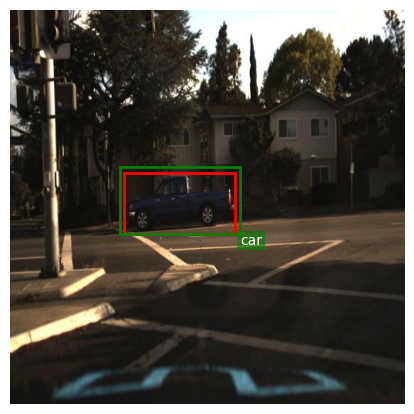

In [19]:
testpred = ssdtestmodel_loaded.predict(images, score_thresh=0.2, max_per_img=200)

# pred_boxs = testpred[0]['boxes'].to('cpu')
# pred_labels = ids_to_names(testpred[0]['labels'].tolist() if type(testpred[0]['labels']) != list else testpred[0]['labels'], mapping=id2name)

toy_set.show_with_box(index=69, color='r', lw=2, label=False, pred_dict=testpred[0], pred_color='g', lw_pred=2, pred_label=True);

In [20]:
loc_all, conf_all = ssdtestmodel_loaded(images)

pos_mask, loc_t_pm, cls_t = build_targets(priors_cxcywh=ssdtestmodel_loaded.priors,
                                                  targets=targets,
                                                  H=300,
                                                  W=300,
                                                  iou_thresh=0.5,
                                                  variances=(0.1, 0.2),
                                                  device=device)

In [21]:
targets

[{'boxes': tensor([[ 86.7188, 124.2188, 171.0938, 170.5078]]),
  'labels': tensor([1]),
  'image_id': tensor([69])}]

In [22]:
B, P, C = conf_all.shape
ce = torch.nn.functional.cross_entropy(conf_all.view(-1, C), cls_t.view(-1), reduction='none').view(B, P)  # [B, P]

ce

tensor([[1.6952e-02, 1.7369e-03, 2.2389e-03,  ..., 2.0907e-04, 4.1484e-05,
         3.2289e-04]], grad_fn=<ViewBackward0>)

In [23]:
# keep CE on positives always
# pos_mask.float() turns true/false into 1/0
ce_pos = (ce * pos_mask.float()).sum()

ce_pos

tensor(7.8407, grad_fn=<SumBackward0>)

In [24]:
# get hardest negatives

# initialize
ce_neg_sum = torch.tensor(0.0, device=device)

# number of positives per image (avoid zero division)
num_pos_per_img = pos_mask.sum(dim=1)                    # [B]
total_pos = num_pos_per_img.sum().clamp_min(1).float()   # scalar

n_pos = int(num_pos_per_img.item())
neg_pos_ratio = 3
if n_pos == 0:
    # still allow some negatives to contribute (common trick: pretend 1 positive)
    max_negs = int(neg_pos_ratio)
else:
    max_negs = int(neg_pos_ratio * n_pos)

print(f"# of positive priors in this image: {num_pos_per_img}")
print(f"Max negatives: {max_negs}")

# of positive priors in this image: tensor([33])
Max negatives: 99


In [30]:
ce_neg_i = ce[0].masked_select(~pos_mask[0])

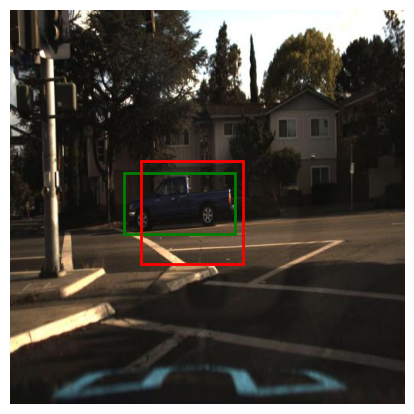

In [ ]:
# hardest negative
toy_set.show_with_box(index=69, color='g', lw=2, label=False, pred_dict={"boxes": priors_xyxy[ce[0].argmax()]}, pred_color='r', lw_pred=2, pred_label=False, pred_ref='normalized');

In [35]:
k = min(max_negs, ce_neg_i.numel())
k

99

In [37]:
topk_vals, _ = torch.topk(ce_neg_i, k, largest=True, sorted=False)

topk_vals

tensor([2.5162, 2.0970, 1.8776, 1.2890, 0.9245, 0.5317, 0.1760, 0.1524, 0.1471,
        0.1452, 0.1316, 0.1087, 0.1068, 0.0823, 0.0680, 0.0635, 0.0534, 0.0490,
        0.0408, 0.0373, 0.0339, 0.0308, 0.0290, 0.0287, 0.0239, 0.0203, 0.0172,
        0.0170, 0.0148, 0.0144, 0.0137, 0.0132, 0.0132, 0.0126, 0.0121, 0.0114,
        0.0112, 0.0106, 0.0104, 0.0099, 0.0088, 0.0086, 0.0084, 0.0081, 0.0080,
        0.0077, 0.0076, 0.0074, 0.0073, 0.0071, 0.0070, 0.0070, 0.0067, 0.0063,
        0.0061, 0.0058, 0.0056, 0.0056, 0.0055, 0.0054, 0.0054, 0.0054, 0.0053,
        0.0053, 0.0052, 0.0048, 0.0047, 0.0043, 0.0042, 0.0041, 0.0040, 0.0040,
        0.0038, 0.0038, 0.0038, 0.0036, 0.0035, 0.0035, 0.0034, 0.0034, 0.0033,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0031, 0.0031, 0.0031, 0.0030,
        0.0030, 0.0029, 0.0029, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0026],
       grad_fn=<TopkBackward0>)

In [38]:
# sum the hardest negatives!
ce_neg_sum += topk_vals.sum()

In [39]:
# overall loss
(ce_pos + ce_neg_sum) / total_pos

tensor(0.5779, grad_fn=<DivBackward0>)

How does ConditionalIoUCrop work?

In [ ]:
min_CIOU_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),

    ConditionalIoUCrop(min_area_frac=0.01,   # 1% threshold between "large" and "small"
                       small_min_scale=0.3,
                       large_min_scale=0.6,
                       max_scale=1.0,
                       min_aspect_ratio=0.75,
                       max_aspect_ratio=1.33,
                       small_sampler_options=(0.0, 0.05, 0.1, 2.0),
                       large_sampler_options=(0.05, 0.1, 0.3, 2.0),
                       trials=10),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.Resize((512, 512), antialias=False),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

toy_set_CIOUtfms = CarImageClass.ImageClass(targ_dir=train_path, transform=min_CIOU_tfms, file_pct=1, rand_seed=724, include_area=False, device='cpu')

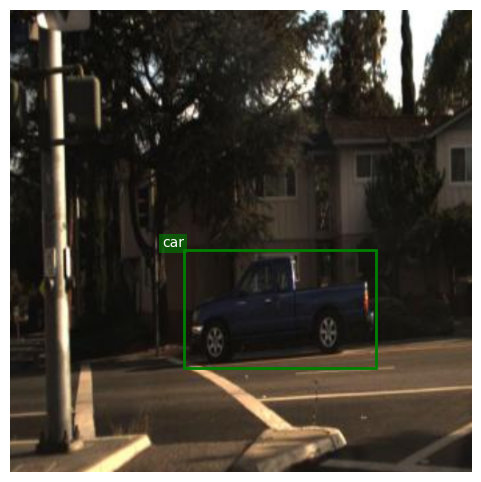

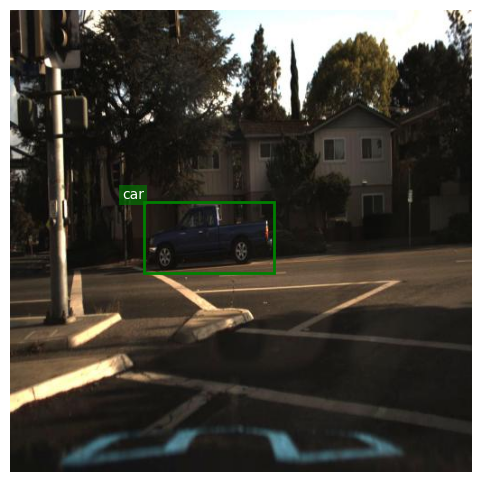

In [27]:
toy_set_CIOUtfms.show_with_box(index=69, color='g', lw=2, label=True);
toy_set.show_with_box(index=69, color='g', lw=2, label=True);

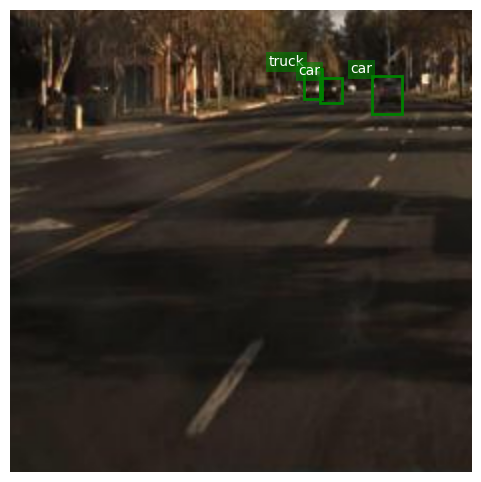

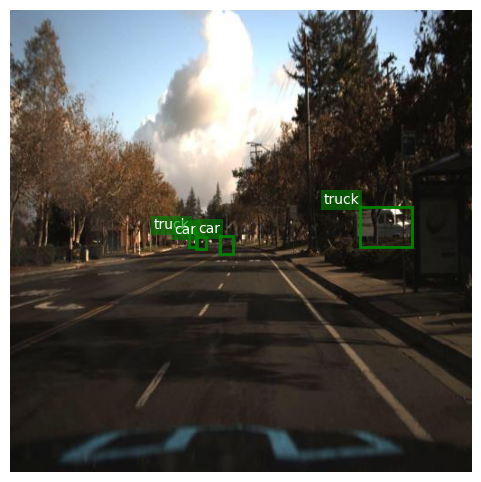

In [51]:
idx = 0

toy_set_CIOUtfms.show_with_box(index=idx, color='g', lw=2, label=True);
toy_set.show_with_box(index=idx, color='g', lw=2, label=True);

In [ ]:
# Load the model
ssd_model = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                  in_channels=3,
                  variances=(0.1, 0.2))

ssd_model.to(device='cpu')

WEIGHTS_PATH = r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\saved_models\weight_only_mAP_432_11_15_2025.pth"

state_dict = torch.load(WEIGHTS_PATH, map_location="cpu")
ssd_model.load_state_dict(state_dict, strict=False)


# Load the training data
# The model only works on images of size 300x300
min_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300,300), antialias=False),
])

# two sets of the same images, one with transformations, one without for clearer displays
train_data_no_tfms = CarImageClass.ImageClass(targ_dir=train_path, file_list=None, transform=None, file_pct=1, rand_seed=724, include_area=True)
train_data = CarImageClass.ImageClass(targ_dir=train_path, file_list=None, transform=min_tfms, file_pct=1, rand_seed=724, include_area=True)

img, target = train_data[69]

In [ ]:
@torch.no_grad()
def predict_no_nms(model: mySSD,
                   images: torch.Tensor,
                   score_thresh: float = 0.2,
                   nms_thresh: float = 0.5,          # kept only for signature parity, unused
                   max_per_img: int = 100,
                   class_agnostic: bool = False,     # unused here
                   ) -> list[Dict[str, object]]:
    """
    Identical to `predict` but **does NOT apply non-maximum suppression**.

    Inputs
    -------
    images : Tensor [B, 3, 300, 300]
    score_thresh : float in [0, 1)
        Per-(prior, class) score threshold.
    nms_thresh : float in (0, 1)
        Ignored here (kept to match the original signature).
    max_per_img : int
        Maximum number of predictions to return per image.
        If more boxes survive the score threshold, only the top `max_per_img`
        by score are kept.
    class_agnostic : bool
        Ignored here (no NMS).
    pre_loc_all : Tensor [B, P, 4] or None
    pre_conf_all : Tensor [B, P, C] or None

    Output
    -------
    List of length B; each element is a dict:
        {
            'labels': LongTensor[K], values in {0, ..., C-2} (foreground indices),
            'scores': FloatTensor[K],
            'boxes' : FloatTensor[K, 4] in xyxy (pixel coords in 300x300 space).
        }
    """

    # score_thresh check (same behaviour as your current version)
    if not (0.0 <= score_thresh < 1.0):
        raise ValueError(
            f"Score threshold should be greater than or equal to 0 and less than 1, received {score_thresh}."
        )

    # NOTE: nms_thresh is intentionally NOT used here

    # eval mode (same side-effect as your current predict)
    model.eval()

    loc_all, conf_all = model(images)  # [B,P,4], [B,P,C]

    B, P, C = conf_all.shape
    device = conf_all.device

    # basic sanity checks consistent with your original code
    assert P == model.priors.shape[0]
    assert C == model.num_classes and C >= 2

    # softmax and drop background (class 0)
    scores_all = conf_all.softmax(dim=-1)[..., 1:]   # [B,P,C-1]

    H, W = model.img_h, model.img_w
    v_c, v_s = model.variance_center, model.variance_size
    priors = model.priors  # [P,4] cxcywh in [0,1]

    out: list[Dict[str, object]] = []

    for b in range(B):
        # scores for this image: [P, num_fg]
        b_scores = scores_all[b]  # [P,C-1]

        # threshold BEFORE decoding
        keep_mask = b_scores > score_thresh  # [P,C-1] boolean
        if not keep_mask.any():
            out.append({
                "labels": torch.empty(0, dtype=torch.int64, device=device),
                "scores": torch.empty(0, dtype=torch.float32, device=device),
                "boxes":  priors.new_zeros((0, 4)),
            })
            continue

        # indices of (prior, class) pairs that survive the score threshold
        # pri_idx: [M], cls0_idx: [M]
        pri_idx, cls0_idx = keep_mask.nonzero(as_tuple=True)

        # select the corresponding loc and priors
        loc_sel    = loc_all[b, pri_idx]  # [M,4]
        priors_sel = priors[pri_idx]      # [M,4]

        # decode these M priors to normalized cxcywh in [0,1]
        boxes_cxcywh = model.decode_ssd(loc=loc_sel,
                                  priors=priors_sel,
                                  variances=(v_c, v_s))  # [M,4]

        cx, cy, w, h = boxes_cxcywh.unbind(dim=1)
        x1 = (cx - 0.5 * w).clamp(0, 1) * W
        y1 = (cy - 0.5 * h).clamp(0, 1) * H
        x2 = (cx + 0.5 * w).clamp(0, 1) * W
        y2 = (cy + 0.5 * h).clamp(0, 1) * H
        sel_boxes = torch.stack([x1, y1, x2, y2], dim=1)  # [M,4], float32

        # scores / labels for these kept (prior, class) pairs
        sel_scores  = b_scores[pri_idx, cls0_idx]  # [M]
        sel_labels0 = cls0_idx                     # [M], 0-based foreground labels

        # OPTIONAL: truncate to max_per_img by score (still no NMS)
        M = sel_scores.numel()
        if max_per_img is not None and M > max_per_img:
            # get top-k indices by score
            topk_scores, topk_idx = torch.topk(sel_scores, k=max_per_img)
            boxes_out  = sel_boxes[topk_idx]
            scores_out = topk_scores
            labels_out = sel_labels0[topk_idx]
        else:
            boxes_out  = sel_boxes
            scores_out = sel_scores
            labels_out = sel_labels0

        out.append({
            "labels": labels_out.to(torch.int64),
            "scores": scores_out.to(torch.float32),
            "boxes":  boxes_out,
        })

    return out


In [ ]:
@torch.no_grad()
def predict_no_nms(model: mySSD,
            images: torch.Tensor,
            score_thresh: float = 0.2,
            nms_thresh: float = 0.5,
            max_per_img: int = 100,
            ) -> list[Dict[str, object]]:
    """
    Inputs
    images: Tensor of size [B, 3, 300, 300]
    score_thresh: Float between 0 and 1 determining the score threshold for kept predictions
    nms_thresh: Float between 0 and 1 determining the non-maximum suppression threshold
    max_per_img: Integer denoting the max amount of predictions per image

    Output
    List of length B; each element is a dict:
    {
        'labels': Tensor, contains values 0, ..., C-2
        'scores': Tensor, contains confidences for each class
        'boxes' : Tensor of size [K,4] in 'xyxy' format
    }
    (B - batch size, P - number of priors (8732), C - number of classes)
    """

    # make sure score, nms threshold are valid
    if not (0.0 <= score_thresh < 1.0):
        raise ValueError(f"Score threshold should be greater than 0 and less than 1, recieved {score_thresh}.")
    
    if not (0.0 < nms_thresh < 1.0):
        raise ValueError(f"NMS threshold should be greater than 0 and less than 1, recieved {nms_thresh}.")
    
    loc_all, conf_all = model(images)                      # (B,P,4), (B,P,C)
    
    B, P, C = conf_all.shape
    device = conf_all.device
    assert P == model.priors.size(0)
    assert C == model.num_classes and C >= 2

    # softmax and drop background
    scores_all = conf_all.softmax(dim=-1)[..., 1:]   # (B,P,C-1)

    H, W = model.img_h, model.img_w
    v_c, v_s = model.variance_center, model.variance_size
    priors = model.priors


    out: list[Dict[str, object]] = []

    for b in range(B):
        # scores for this image: [P,num_fg]
        b_scores = scores_all[b]

        # threshold BEFORE decoding
        keep_mask = b_scores > score_thresh  # [P,num_fg]
        if not keep_mask.any():
            out.append({
                "labels": torch.empty(0, dtype=torch.int64, device=device),
                "scores": torch.empty(0, dtype=torch.float32, device=device),
                "boxes":  priors.new_zeros((0, 4))
            })
            continue
        # indices of priors and class-ids that survive threshold
        # pri_idx: [M], cls0_idx: [M]
        pri_idx, cls0_idx = keep_mask.nonzero(as_tuple=True)

        # slice loc + priors to those M priors
        loc_sel    = loc_all[b, pri_idx]  # [M,4] offsets for kept priors
        priors_sel = priors[pri_idx]      # [M,4] priors for kept priors

        # decode only these M priors to normalized cxcywh
        boxes_cxcywh = model.decode_ssd(loc=loc_sel, priors=priors_sel, variances=(v_c, v_s))  # [M,4]

        cx, cy, w, h = boxes_cxcywh.unbind(dim=1)
        x1 = (cx - 0.5 * w).clamp(0, 1) * W
        y1 = (cy - 0.5 * h).clamp(0, 1) * H
        x2 = (cx + 0.5 * w).clamp(0, 1) * W
        y2 = (cy + 0.5 * h).clamp(0, 1) * H
        sel_boxes = torch.stack([x1, y1, x2, y2], dim=1)  # [M,4]

        # scores / labels for these kept (prior, class) pairs
        sel_scores  = b_scores[pri_idx, cls0_idx]  # [M]
        sel_labels0 = cls0_idx                     # [M], 0-based foreground labels

        # # NMS
        # if class_agnostic:
        #     keep = self.iou_nms(sel_boxes, sel_scores, iou_threshold=nms_thresh)
        #     # ensure highest-score first before truncation
        #     keep = keep[sel_scores[keep].argsort(descending=True)]
        # else:
        #     # sort once
        #     order = torch.argsort(sel_labels0)
        #     boxes  = sel_boxes[order]
        #     scores = sel_scores[order]
        #     labels = sel_labels0[order]

        #     kept = []
        #     i = 0
        #     N = labels.numel()
        #     while i < N:
        #         c = labels[i].item()

        #         # find the contiguous block [i, j) where labels == c
        #         j = i + 1
        #         while j < N and labels[j].item() == c:
        #             j += 1

        #         # NMS on boxes[i:j]
        #         local_keep = self.iou_nms(boxes[i:j], scores[i:j], iou_threshold=nms_thresh)
        #         kept.append(torch.arange(i, j, device=boxes.device)[local_keep])

        #         i = j

        #     keep = torch.cat(kept, dim=0)
        #     keep = order[keep]  # map back to indices in sel_* space
        #     keep = keep[sel_scores[keep].argsort(descending=True)]

        # keep = keep[:max_per_img]

        order = torch.argsort(sel_labels0)
        labels_out = sel_labels0[order]                                       # Tensor
        scores_out = sel_scores[order]                                        # Tensor
        boxes_out  = sel_boxes[order]                                         # Tensor[K,4]

        out.append({"labels": labels_out,
                    "scores": scores_out,
                    "boxes": boxes_out})

    return out

In [ ]:
# make prediction without NMS
pred_no_nms = predict_no_nms(model=ssd_model, images=img.unsqueeze(dim=0), score_thresh=0.2, nms_thresh=0.4, max_per_img=100)

# Mold prediction to 
labels = pred_no_nms[0]["labels"]  # [n]
boxes  = pred_no_nms[0]["boxes"] / torch.tensor([300,300,300,300])   # normalize

assert labels.shape[0] == boxes.shape[0], "Mismatch in n between labels and boxes"
n = labels.shape[0]

list_of_dicts = [{"labels": labels[i : i+1], "boxes":  boxes[i : i+1],} for i in range(n)]

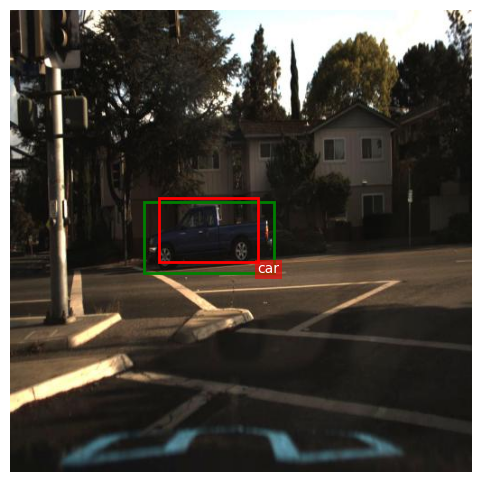

In [ ]:
pred_with_nms = ssd_model.predict(images=img.unsqueeze(dim=0), score_thresh=0.2, nms_thresh=0.4)
pred_with_nms[0]['boxes'] /= torch.tensor([300,300,300,300])

train_data_no_tfms.show_with_box(index=69, color='g', lw=2, label=False, pred_dict=pred_with_nms[0], pred_color='r', lw_pred=2, pred_label=True, pred_ref='normalized');

In [ ]:
def make_pred_gif(toy_set, index: int, pred_dict_list, gif_path, duration=500):
    frames = []

    for n in range(len(pred_dict_list)):
        # Get the figure that show_with_box actually creates
        fig = toy_set.show_with_box(
            index=index,
            color='g',
            lw=2,
            label=False,
            pred_dict=pred_dict_list[n],
            pred_color='r',
            lw_pred=2,
            pred_label=True,
            pred_ref='normalized'
        )

        # Render and grab pixels
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()

        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        buf = buf.reshape((h, w, 4))  # [H, W, 4]

        # Take the first axes (assuming show_with_box creates one main axes)
        ax = fig.axes[0]
        bbox = ax.get_window_extent()  # in display (pixel) coords
        x0, y0, x1, y1 = bbox.extents
        x0, y0, x1, y1 = [int(v) for v in (x0, y0, x1, y1)]

        # Crop to axes region
        buf_cropped = buf[y0:y1, x0:x1, :]  # [h_c, w_c, 4]
        img = buf_cropped[..., :3].copy()   # RGB

        # ---- Add a small white border around the cropped image ----
        border = 4  # adjust this to taste
        h_c, w_c, _ = img.shape

        # White background (255,255,255)
        framed = np.full(
            (h_c + 2*border, w_c + 2*border, 3),
            255,
            dtype=np.uint8
        )

        # Put the image in the center
        framed[border:border + h_c, border:border + w_c, :] = img

        frames.append(framed)

        plt.close(fig)

    imageio.mimsave(gif_path, frames, duration=duration, loop=0)
    return gif_path

In [ ]:
make_pred_gif(toy_set=train_data_no_tfms, index=69, pred_dict_list=list_of_dicts, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\pred_no_nms.gif")

'C:\\Users\\eblac\\OneDrive\\Documents\\GitHub\\self-driving-car\\figures\\pred_no_nms.gif'

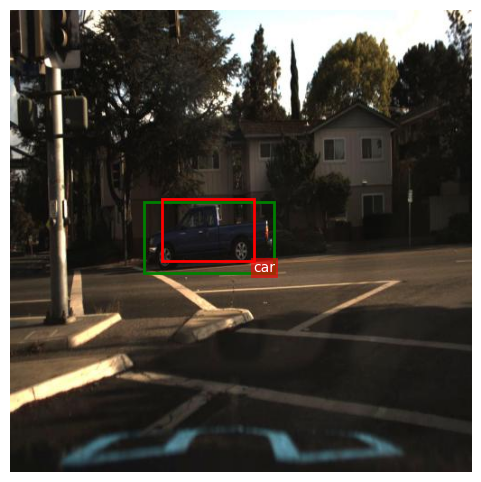

In [ ]:
train_data_no_tfms.show_with_box(index=69, color='g', lw=2, label=False, pred_dict=pred_with_nms[0], pred_color='r', lw_pred=2, pred_label=True, pred_ref='size');

# Precision and Recall

\begin{equation*}
    \text{Precision} = \frac{\text{\# TP}}{\text{\# TP} + \text{\# FP}}, \quad \text{Recall} = \frac{\text{\# TP}}{\text{\# TP} + \text{\# FN}}
\end{equation*}

Each ground truth (GT) object has:
* a bounding box $g$,
* classification label $c^{g}_{i}$,

 where $c_{j}$, $j=1,\ldots, C$, are the possible classes and the superscript denotes the object.
 
Each predicted object has:
* a bounding box $\hat{g}$,
* classification label $c^{\hat{g}}_{k}$,
* a confidence score $s^{\hat{g}}$,

where $s^{\hat{g}}$ is the highest confidence score among all classes for the object $\hat{g}$, i.e. $s^{\hat{g}}=\max\limits_{i=1,\ldots,C}s^{\hat{g}}_{i}$, where $s^{\hat{g}}_{i}$ is the confidence score of class $i$ for object $\hat{g}$.

#### True positive (TP)
A predicted object corresponding to a GT is TP if all of the following are true:
* classes match (i.e. $k=i$)
* spatial match, typically $\mathrm{IoU}(g, \hat{g}) \geq \text{IoU threshold}$,
* the confidence score $s^{\hat{g}} = s^{\hat{g}}_{i}$, i.e. class $i$ gives the highest confidence score.

#### False positive (FP)
A predicted object is a FP is any of the following are true:
* not a spatial match, typically $\mathrm{IoU}(g, \hat{g}) < \text{IoU threshold}$,
* wrong class (i.e. $k\neq i$),
* duplicate detection (there is another prediction with better spatial match)
* prediction on background (predicting a class that is not present in current image)

In other words, a FP is a predicted detection that fails to be a valid match to any new ground-truth object of the correct class at the chosen IoU threshold, given the standard “each ground truth can only be matched once” rule.

#### False negative (FN)
A False Negative (FN) is a ground-truth object of class $c$ that is not matched by any prediction of class $c$ with $\mathrm{IoU}(g, \hat{g}) \geq \text{IoU threshold}$.